# Lab 6: Transformers Tutorial

In this tutorial, we'll reproduce, step by step, the model from the paper that first introduced the transformer architecture, [Attention Is All You Need](https://arxiv.org/abs/1706.03762)), albeit only the encoder part.
After that, we'll do a number of small experiments to visualize and better understand the inner workings.



In [1]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np 
import math
from functools import partial
import seaborn as sns
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

DATASET_PATH = "data"
CHECKPOINT_PATH = "saved_models"

# Setting the seed
pl.seed_everything(42)
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cpu"
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
print("Device:", device)

Seed set to 42


Device: mps


### Attention mechanism

The attention mechanism describes a weighted average of (sequence) elements with the weights dynamically computed based on an input query and elements' keys. In other words, we want to dynamically decide on which inputs we want to "attend" more than others. To implement the attention mechanism, there are four parts we need to specify:

* **Query**: The query is a feature vector that describes what we are looking for in the sequence, i.e. what would we maybe want to pay attention to.
* **Keys**: For each input element, we have a key which is again a feature vector. This feature vector roughly describes what the element is "offering", or when it might be important. The keys should be designed such that we can identify the elements we want to pay attention to based on the query.
* **Values**: For each input element, we also have a value vector. This feature vector is the one we want to average over.

The weights of the average are calculated by a softmax over all score function outputs.

The dot product attention takes as input a set of queries $Q\in\mathbb{R}^{T\times d_k}$, keys $K\in\mathbb{R}^{T\times d_k}$ and values $V\in\mathbb{R}^{T\times d_v}$ where $T$ is the sequence length, and $d_k$ and $d_v$ are the hidden dimensionality for queries/keys and values respectively. For simplicity, we neglect the batch dimension for now. The attention value from element $i$ to $j$ is based on its similarity of the query $Q_i$ and key $K_j$, using the dot product as the similarity metric.

$$\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

The matrix multiplication $QK^T$ performs the dot product for every possible pair of queries and keys, resulting in a matrix of the shape $T\times T$. Each row represents the attention logits for a specific element $i$ to all other elements in the sequence. On these, we apply a softmax and multiply with the value vector to obtain a weighted mean (the weights being determined by the attention). Another perspective on this attention mechanism offers the computation graph which is visualized below (figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).

<center width="100%"><img src="../notebooks/images/scaled_dot_product_attn.svg" width="210px"></center>

The scaling factor of $1/\sqrt{d_k}$ is crucial to maintain an appropriate variance of attention values after initialization. The block `Mask (opt.)` in the diagram above represents the optional masking of specific entries in the attention matrix. This is usually done by setting the respective attention logits to a very low value. 

We can write a function below which computes the output features given the triple of queries, keys, and values:

In [ ]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

Let's generate a few random queries, keys, and value vectors, and calculate the attention outputs:

In [33]:
seq_len, d_k = 3, 2
pl.seed_everything(42)
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)
values, attention = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Seed set to 42


Q
 tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]])
K
 tensor([[ 2.2082, -0.6380],
        [ 0.4617,  0.2674],
        [ 0.5349,  0.8094]])
V
 tensor([[ 1.1103, -1.6898],
        [-0.9890,  0.9580],
        [ 1.3221,  0.8172]])
Values
 tensor([[ 0.5698, -0.1520],
        [ 0.5379, -0.0265],
        [ 0.2246,  0.5556]])
Attention
 tensor([[0.4028, 0.2886, 0.3086],
        [0.3538, 0.3069, 0.3393],
        [0.1303, 0.4630, 0.4067]])


### Multi-Head Attention

The scaled dot product attention allows a network to attend over a sequence. However, often there are multiple different aspects a sequence element wants to attend to, and a single weighted average is not a good option for it. This is why we extend the attention mechanisms to multiple heads, i.e. multiple different query-key-value triplets on the same features. We refer to this as Multi-Head Attention layer with the learnable parameters $W_{1...h}^{Q}\in\mathbb{R}^{D\times d_k}$, $W_{1...h}^{K}\in\mathbb{R}^{D\times d_k}$, $W_{1...h}^{V}\in\mathbb{R}^{D\times d_v}$, and $W^{O}\in\mathbb{R}^{h\cdot d_v\times d_{out}}$ ($D$ being the input dimensionality). Expressed in a computational graph, we can visualize it as below (figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).

<center width="100%"><img src="../notebooks/images/multihead_attention.svg" width="230px"></center>

How are we applying a Multi-Head Attention layer in a neural network, where we don't have an arbitrary query, key, and value vector as input? Looking at the computation graph above, a simple but effective implementation is to set the current feature map in a NN, $X\in\mathbb{R}^{B\times T\times d_{\text{model}}}$, as $Q$, $K$ and $V$ ($B$ being the batch size, $T$ the sequence length, $d_{\text{model}}$ the hidden dimensionality of $X$). The consecutive weight matrices $W^{Q}$, $W^{K}$, and $W^{V}$ can transform $X$ to the corresponding feature vectors that represent the queries, keys, and values of the input. Using this approach, we can implement the Multi-Head Attention module below.

In [4]:
# Helper function to support different mask shapes.
# Output shape supports (batch_size, number of heads, seq length, seq length)
# If 2D: broadcasted over batch size and number of heads
# If 3D: broadcasted over number of heads
# If 4D: leave as is
def expand_mask(mask):
    assert mask.ndim >= 2, "Mask must be at least 2-dimensional with seq_length x seq_length"
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = mask.unsqueeze(0)
    return mask

In [5]:
class MultiheadAttention(nn.Module):
    
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, input_dim)
        
        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        if mask is not None:
            mask = expand_mask(mask)
        qkv = self.qkv_proj(x)
        
        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)
        
        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)
        
        if return_attention:
            return o, attention
        else:
            return o

### Transformer Encoder

Next, we will look at how to apply the multi-head attention block inside the Transformer architecture. Originally, the Transformer model was designed for machine translation. Hence, it got an encoder-decoder structure where the encoder takes as input the sentence in the original language and generates an attention-based representation. On the other hand, the decoder attends over the encoded information and generates the translated sentence in an autoregressive manner. We will focus here on the encoder part. If you have understood the encoder architecture, the decoder is a very small step to implement as well. The full Transformer architecture looks as follows (figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).:

<center width="100%"><img src="../notebooks/images/transformer_architecture.svg" width="400px"></center>

The encoder consists of $N$ identical blocks that are applied in sequence. Taking as input $x$, it is first passed through a Multi-Head Attention block as we have implemented above. The output is added to the original input using a residual connection, and we apply a consecutive Layer Normalization on the sum. Overall, it calculates $\text{LayerNorm}(x+\text{Multihead}(x,x,x))$ ($x$ being $Q$, $K$ and $V$ input to the attention layer). The residual connection is crucial for enabling a smooth gradient flow through the model, and to make sure that the information about the original sequence isn't lost. The Layer Normalization also plays an important role in the Transformer architecture as it enables faster training and provides small regularization. Additionally, it ensures that the features are in a similar magnitude among the elements in the sequence. Finally, a small fully connected feed-forward network is added to the model, which is applied to each position separately and identically. The full transformation including the residual connection can be expressed as:  

$$
\begin{split}
    \text{FFN}(x) & = \max(0, xW_1+b_1)W_2 + b_2\\
    x & = \text{LayerNorm}(x + \text{FFN}(x))
\end{split}
$$

Finally, we can start implementing the architecture below. We first start by implementing a single encoder block. Additionally to the layers described above, we will add dropout layers in the MLP and on the output of the MLP and Multi-Head Attention for regularization.

In [6]:
class EncoderBlock(nn.Module):
    
    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()
        
        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)
        
        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )
        
        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)
        
        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)
        
        return x

Based on this block, we can implement a module for the full Transformer encoder. Additionally to a forward function that iterates through the sequence of encoder blocks, we also provide a function called `get_attention_maps`. The idea of this function is to return the attention probabilities for all Multi-Head Attention blocks in the encoder. This helps us in understanding the model later. However, the attention probabilities should be interpreted with a grain of salt as it [does not necessarily reflect the true interpretation of the model](https://arxiv.org/abs/1902.10186).

In [7]:
class TransformerEncoder(nn.Module):
    
    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps

### Positional encoding

We have discussed before that the Multi-Head Attention block is permutation-equivariant, and cannot distinguish whether an input comes before another one in the sequence or not. However, we can use patterns that the network can identify from the features and potentially generalize to larger sequences. The specific pattern chosen by Vaswani et al. are sine and cosine functions of different frequencies, as follows:

$$
PE_{(pos,i)} = \begin{cases}
    \sin\left(\frac{pos}{10000^{i/d_{\text{model}}}}\right) & \text{if}\hspace{3mm} i \text{ mod } 2=0\\
    \cos\left(\frac{pos}{10000^{(i-1)/d_{\text{model}}}}\right) & \text{otherwise}\\
\end{cases}
$$

$PE_{(pos,i)}$ represents the position encoding at position $pos$ in the sequence, and hidden dimensionality $i$. The intuition behind this encoding is that you can represent $PE_{(pos+k,:)}$ as a linear function of $PE_{(pos,:)}$, which might allow the model to easily attend to relative positions. The wavelengths in different dimensions range from $2\pi$ to $10000\cdot 2\pi$. The positional encoding is implemented below.

In [8]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model) 
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

To understand the positional encoding, we can visualize it below. We will generate an image of the positional encoding over hidden dimensionality and position in a sequence. Each pixel, therefore, represents the change of the input feature we perform to encode the specific position. Let's do it below.

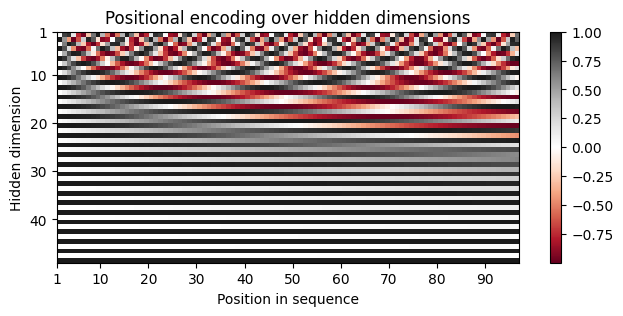

In [9]:
encod_block = PositionalEncoding(d_model=48, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

You can clearly see the sine and cosine waves with different wavelengths that encode the position in the hidden dimensions. Specifically, we can look at the sine/cosine wave for each hidden dimension separately, to get a better intuition of the pattern. Below we visualize the positional encoding for the hidden dimensions $1$, $2$, $3$ and $4$.

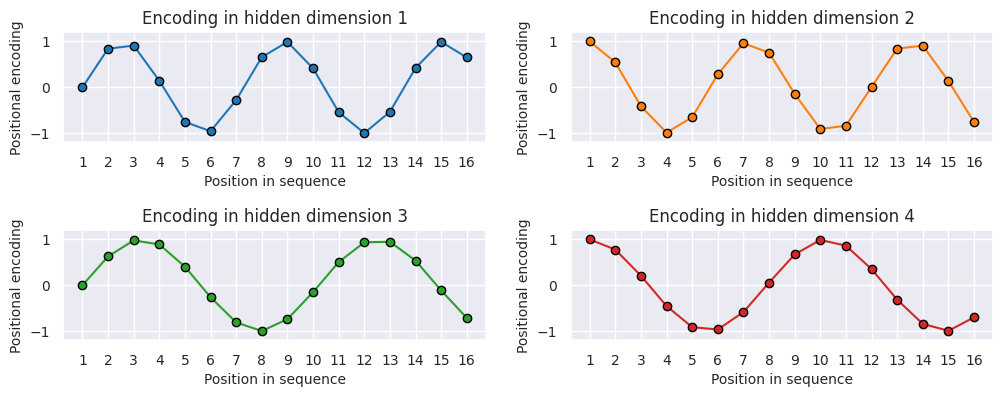

In [10]:
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12,4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1,17), pe[i,:16], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title(f"Encoding in hidden dimension {i+1}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1,17))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()

As we can see, the patterns between the hidden dimension $1$ and $2$ only differ in the starting angle. The wavelength is $2\pi$, hence the repetition after position $6$. The hidden dimensions $2$ and $3$ have about twice the wavelength. 

### Learning rate warm-up

One commonly used technique for training a Transformer is learning rate warm-up. This means that we gradually increase the learning rate from 0 on to our originally specified learning rate in the first few iterations.

In [11]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):
    
    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)
        
    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]
    
    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

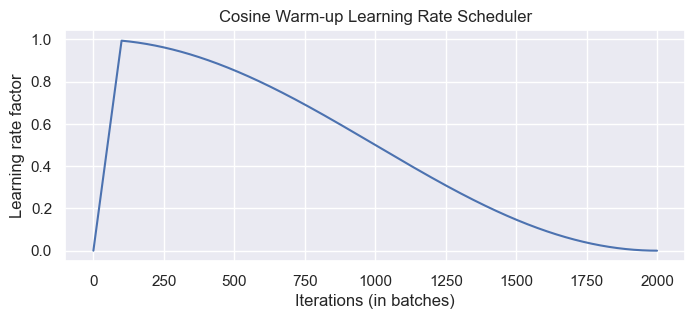

In [12]:
# Needed for initializing the lr scheduler
p = nn.Parameter(torch.empty(4,4))
optimizer = optim.Adam([p], lr=1e-3)
lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler.get_lr_factor(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

### PyTorch Lightning Module

Finally, we can embed the Transformer architecture into a PyTorch lightning module. We will implement a template for a classifier based on the Transformer encoder. Thereby, we have a prediction output per sequence element. If we would need a classifier over the whole sequence, the common approach is to add an additional `[CLS]` token to the sequence, representing the classifier token. However, here we focus on tasks where we have an output per element.

Additionally to the Transformer architecture, we add a small input network (maps input dimensions to model dimensions), the positional encoding, and an output network (transforms output encodings to predictions). The training, validation, and test step is left empty for now and will be filled for our task-specific models.

In [13]:
class TransformerPredictor(pl.LightningModule):

    def __init__(self, input_dim, model_dim, num_classes, num_heads, num_layers, lr, warmup, max_iters, dropout=0.0, input_dropout=0.0):
        """
        Inputs:
            input_dim - Hidden dimensionality of the input
            model_dim - Hidden dimensionality to use inside the Transformer
            num_classes - Number of classes to predict per sequence element
            num_heads - Number of heads to use in the Multi-Head Attention blocks
            num_layers - Number of encoder blocks to use.
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout - Dropout to apply inside the model
            input_dropout - Dropout to apply on the input features
        """
        super().__init__()
        self.save_hyperparameters()
        self._create_model()

    def _create_model(self):
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Dropout(self.hparams.input_dropout),
            nn.Linear(self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=self.hparams.model_dim)
        # Transformer
        self.transformer = TransformerEncoder(num_layers=self.hparams.num_layers,
                                              input_dim=self.hparams.model_dim,
                                              dim_feedforward=2*self.hparams.model_dim,
                                              num_heads=self.hparams.num_heads,
                                              dropout=self.hparams.dropout)
        # Output classifier per sequence lement
        self.output_net = nn.Sequential(
            nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
            nn.LayerNorm(self.hparams.model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.hparams.dropout),
            nn.Linear(self.hparams.model_dim, self.hparams.num_classes)
        ) 

    def forward(self, x, mask=None, add_positional_encoding=True):
        """
        Inputs:
            x - Input features of shape [Batch, SeqLen, input_dim]
            mask - Mask to apply on the attention outputs (optional)
            add_positional_encoding - If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)
        return x

    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)
        
        # Apply lr scheduler per step
        lr_scheduler = CosineWarmupScheduler(optimizer, 
                                             warmup=self.hparams.warmup, 
                                             max_iters=self.hparams.max_iters)
        return [optimizer], [{'scheduler': lr_scheduler, 'interval': 'step'}]

    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError    

    def test_step(self, batch, batch_idx):
        raise NotImplementedError   

That's it for now. You are now ready to start the labs.

## Further reading

* [Transformer: A Novel Neural Network Architecture for Language Understanding (Jakob Uszkoreit, 2017)](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html) - The original Google blog post about the Transformer paper, focusing on the application in machine translation.
* [The Illustrated Transformer (Jay Alammar, 2018)](http://jalammar.github.io/illustrated-transformer/) - A very popular and great blog post intuitively explaining the Transformer architecture with many nice visualizations. The focus is on NLP.
* [Attention? Attention! (Lilian Weng, 2018)](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html) - A nice blog post summarizing attention mechanisms in many domains including vision.
* [Illustrated: Self-Attention (Raimi Karim, 2019)](https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a) - A nice visualization of the steps of self-attention. Recommended going through if the explanation below is too abstract for you.
* [The Transformer family (Lilian Weng, 2020)](https://lilianweng.github.io/lil-log/2020/04/07/the-transformer-family.html) - A very detailed blog post reviewing more variants of Transformers besides the original one.

This tutorial was greatly inspired by the [UvA Deep Learning tutorials](https://uvadlc-notebooks.readthedocs.io/)